# Active Learning Experiments

## Strategy Comparison

In [7]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# Cifar-10
client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar10')
experiment_id = '108219589658745220'

# STL 10
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/stl10')
# experiment_id = '325147658587907143'

# Cifar-100
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar100')
# experiment_id = '754775338603262051'

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = ''

runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 300 experiments


In [57]:
runs = []
init_query_list = [
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.al.num_init_samples = '10'",
    "parameter.al.num_acq = '10'",
    "parameter.al.acq_size = '10'",
    "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'entropy'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bald'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'pseudo_badge'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bald'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'pseudo_entropy'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

print('Found {} experiments'.format(len(runs)))

Found 699 experiments


In [22]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    if len(run.data.metrics) == 0: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    if len(acc_history) < 11: continue
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


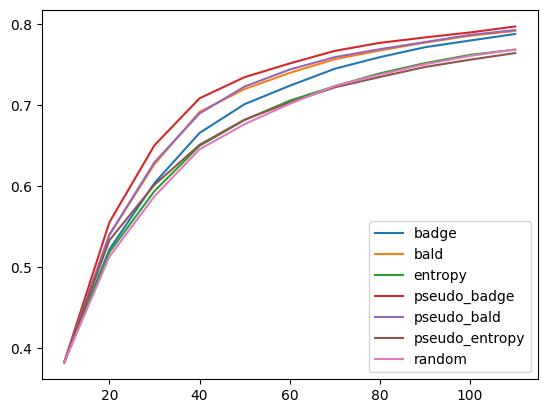

In [23]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

In [51]:
results = {}
for al_strat in al_strats:
    lcs = np.array(learning_curves[al_strat])
    mean_lc = np.mean(lcs, axis=0)
    AUC = np.mean(mean_lc)
    results[al_strat] = AUC
df = pd.DataFrame(results.values()).T
df.columns = results.keys()
df.index = ['ACC']
print(df.to_markdown())

|     |   badge |     bald |   entropy |   pseudo_badge |   pseudo_bald |   pseudo_entropy |   random |
|:----|--------:|---------:|----------:|---------------:|--------------:|-----------------:|---------:|
| ACC | 0.67638 | 0.688827 |  0.661356 |       0.699523 |      0.690161 |          0.66145 | 0.658728 |


## Comparing to single-instance Acquisition

In [67]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# Cifar-10
client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar10')
experiment_id = '108219589658745220'

# STL 10
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/stl10')
# experiment_id = '325147658587907143'

# Cifar-100
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar100')
# experiment_id = '754775338603262051'

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = ''

runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 1000 experiments


In [74]:
runs = []
init_query_list = [
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.al.num_init_samples = '10'",
    "parameter.al.num_acq = '10'",
    "parameter.al.acq_size = '10'",
    "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# Entropy
# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_entropy'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'entropy'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'entropy'"]
# query_list[-3] = "parameter.al.num_acq = '100'"
# query_list[-4] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' + r.data.params['al.strategy']
# runs.extend(runs_)

# BALD
# query_list = init_query_list + ["parameter.al.strategy = 'bald'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bald'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'bald'"]
# query_list[-3] = "parameter.al.num_acq = '100'"
# query_list[-4] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' + r.data.params['al.strategy']
# runs.extend(runs_)

# Badge
# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_badge'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
# query_list[-3] = "parameter.al.num_acq = '100'"
# query_list[-4] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' +  r.data.params['al.strategy']
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 399 experiments


In [75]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    if len(run.data.metrics) == 0: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    if len(acc_history) < 11: continue
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


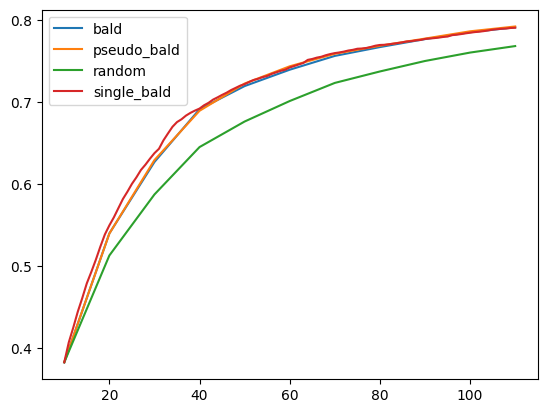

In [76]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

### Model Comparison

In [34]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al_cifar10')
experiment_id = '234235922267199078'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [35]:
query_list = [
    "parameter.dataset_name = 'cifar10'",
    "parameter.dino_model_name = 'dinov2_vitl14'",
    # "parameter.model.name = 'laplace'",
    # "parameter.model.num_epochs = '200'",
    "parameter.model.scale_random_features = 'True'",
    "parameter.al.strategy = 'random'",
    "parameter.al.num_init_samples = '10'",
    "parameter.al.num_acq = '10'",
    "parameter.al.acq_size = '10'",
    "parameter.update_lmb = '1'",
    "parameter.update_gamma = '1'",
]
query = ' and '.join(query_list)
runs = client.search_runs(experiment_ids=experiment_id, filter_string=query)
print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [36]:
models = np.unique([run.data.params['model.name'] for run in runs])

learning_curves = {k: [] for k in models}

for run in runs:
    model_name = run.data.params['model.name']
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[model_name].append([metric.value for metric in acc_history])

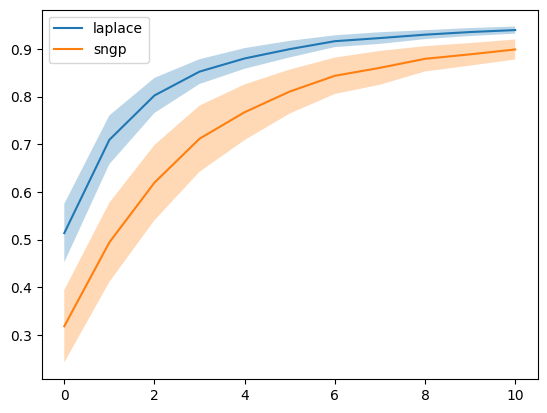

In [37]:
lcs = learning_curves['laplace']
lc = np.mean(lcs, axis=0)
lc_std = np.std(lcs, axis=0)

plt.plot(lc, label='laplace')
plt.fill_between(range(len(lc)), lc - lc_std, lc + lc_std, alpha=.3)

lcs = learning_curves['sngp']
lc = np.mean(lcs, axis=0)
lc_std = np.std(lcs, axis=0)

plt.plot(lc, label='sngp')
plt.fill_between(range(len(lc)), lc - lc_std, lc + lc_std, alpha=.3)

plt.legend()
plt.show()

### Gamma comparison

In [25]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar10')
experiment_id = '689034260454490204'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 1000 experiments


In [26]:
query_list = [
    "parameter.dataset_name = 'cifar10'",
    "parameter.model.name = 'sngp'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.al.strategy = 'pseudo_entropy'",
    "parameter.al.num_init_samples = '10'",
    "parameter.al.num_acq = '10'",
    "parameter.al.acq_size = '10'",
    # "parameter.model.num_epochs = '200'",
    "parameter.model.scale_random_features = 'True'",
    "parameter.update_lmb = '1'",
    # "parameter.update_gamma = '10'",
]
query = ' and '.join(query_list)
runs = client.search_runs(experiment_ids=experiment_id, filter_string=query)

# runs = [run for run in runs if run.data.params['al.strategy'] != 'pseudo_entropy']
# query_list[-1]  = "parameter.update_gamma = '1'"
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

print('Found {} experiments'.format(len(runs)))

Found 693 experiments


In [27]:
gammas = np.unique([run.data.params['update_gamma'] for run in runs])

learning_curves = {k: [] for k in gammas}

for run in runs:
    gamma = run.data.params['update_gamma']
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[gamma].append([metric.value for metric in acc_history])

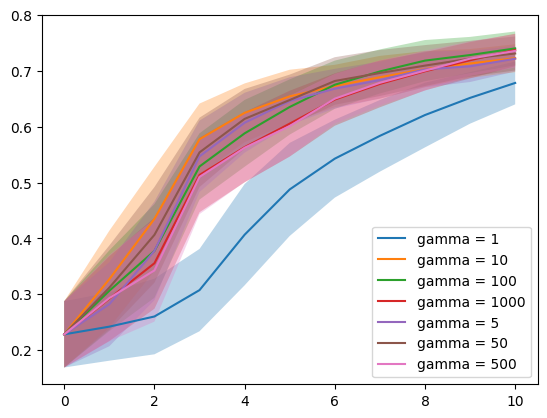

In [28]:
for gamma in learning_curves:
    lcs = learning_curves[gamma]
    lc = np.mean(lcs, axis=0)
    lc_std = np.std(lcs, axis=0)

    plt.plot(lc, label=f'gamma = {gamma}')
    plt.fill_between(range(len(lc)), lc - lc_std, lc + lc_std, alpha=.3)

plt.legend()
plt.show()